In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import env

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import acquire


**Overfitting of data**

When a model is overfit, it's too smart for the training dataset : It is too attuned to the parameters of the training dataset, and makes poor predicitions on out-of-sample data, ie, in the validation and test datasets.  

Example :   

    A data science curriculum tailored to a specific classroom of students, not all future DS students.   
    Custom-made clothing not fitting the general population.

### Summarise the data

In [2]:
tidf = acquire.get_titanic_data(env.sql_connexion)
tidf.tail(3)

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
888,888,888,0,3,female,NaN,1,2,23.45,S,Third,NaN,Southampton,0
889,889,889,1,1,male,26.0,0,0,30.00,C,First,C,Cherbourg,1
890,890,890,0,3,male,32.0,0,0,7.75,Q,Third,NaN,Queenstown,1


1 / Only looking at a single one variable at a time : univariate analysis.  

Relationships between variables are to be examined in only the training dataset.

In [3]:
print(tidf.shape)
print('-.-.-.-.-')
print('-.-.-.-.-')
print(tidf.info())

(891, 14)
-.-.-.-.-
-.-.-.-.-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    891 non-null    int64  
 1   passenger_id  891 non-null    int64  
 2   survived      891 non-null    int64  
 3   pclass        891 non-null    int64  
 4   sex           891 non-null    object 
 5   age           714 non-null    float64
 6   sibsp         891 non-null    int64  
 7   parch         891 non-null    int64  
 8   fare          891 non-null    float64
 9   embarked      889 non-null    object 
 10  class         891 non-null    object 
 11  deck          203 non-null    object 
 12  embark_town   889 non-null    object 
 13  alone         891 non-null    int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 97.6+ KB
None


In [4]:
tidf.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,891.0,445.000000,257.353842,0.00,222.5000,445.0000,667.5,890.0000
passenger_id,891.0,445.000000,257.353842,0.00,222.5000,445.0000,667.5,890.0000
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
alone,891.0,0.602694,0.489615,0.00,0.0000,1.0000,1.0,1.0000


In [5]:
tidf.select_dtypes(exclude = 'object')

,Unnamed: 0,passenger_id,survived,pclass,age,sibsp,parch,fare,alone
0,0,0,0,3,22.0,1,0,7.2500,0
1,1,1,1,1,38.0,1,0,71.2833,0
2,2,2,1,3,26.0,0,0,7.9250,1
3,3,3,1,1,35.0,1,0,53.1000,0
4,4,4,0,3,35.0,0,0,8.0500,1
...,...,...,...,...,...,...,...,...,...
886,886,886,0,2,27.0,0,0,13.0000,1
887,887,887,1,1,19.0,0,0,30.0000,1
888,888,888,0,3,NaN,1,2,23.4500,0
889,889,889,1,1,26.0,0,0,30.0000,1


In [6]:
numerical_columns = tidf.select_dtypes(exclude = 'object').columns.to_list()
numerical_columns

['Unnamed: 0',
 'passenger_id',
 'survived',
 'pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'alone']

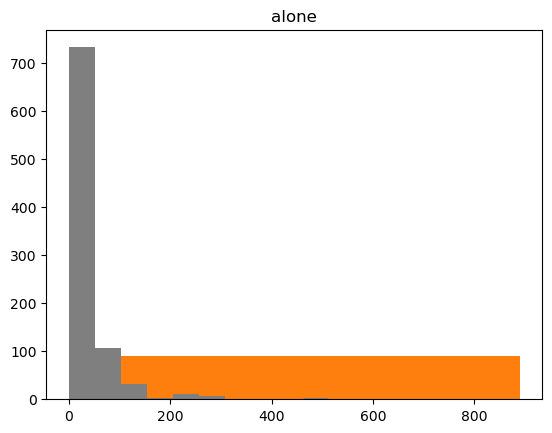

In [7]:
for col in numerical_columns:
    plt.hist(tidf[col])
    plt.title(col)
#    plt.show()

 #   plt.hist(tidf['passenger'])

In [8]:
tidf.select_dtypes(include = 'object')

,sex,embarked,class,deck,embark_town
0,male,S,Third,NaN,Southampton
1,female,C,First,C,Cherbourg
2,female,S,Third,NaN,Southampton
3,female,S,First,C,Southampton
4,male,S,Third,NaN,Southampton
...,...,...,...,...,...
886,male,S,Second,NaN,Southampton
887,female,S,First,B,Southampton
888,female,S,Third,NaN,Southampton
889,male,C,First,C,Cherbourg


In [9]:
categorical_columns = tidf.select_dtypes(include = 'object').columns.to_list()
categorical_columns

# putting all the 'object' columns into a list

['sex', 'embarked', 'class', 'deck', 'embark_town']

In [10]:
# making a loop for plotting

for col in categorical_columns:
    # looking at value counts bc each column contains words, not numbers
    print(tidf[col].value_counts())
    print('-.-.-.-.-.-.-.-.-.-.-.-.-.-')

male      577
female    314
Name: sex, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-
S    644
C    168
Q     77
Name: embarked, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-
Third     491
First     216
Second    184
Name: class, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: deck, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-
Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-


    There is duplicate information: 'embarked' and 'embark_town', 'class' and 'pclass'.  
    
    What to do about all the null values in 'deck' ? Drop the column.  
    
    The 'Passenger_id' is too similar to the index, so we also drop pid.  
    
    Drop 'age' because too many values (177) are missing, and we don't have enough context to impute ages.
    

In [11]:
tidf.isna().sum()

Unnamed: 0        0
passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [12]:
tidf[tidf['age'].isna()]

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
5,5,5,0,3,male,NaN,0,0,8.4583,Q,Third,NaN,Queenstown,1
17,17,17,1,2,male,NaN,0,0,13.0000,S,Second,NaN,Southampton,1
19,19,19,1,3,female,NaN,0,0,7.2250,C,Third,NaN,Cherbourg,1
26,26,26,0,3,male,NaN,0,0,7.2250,C,Third,NaN,Cherbourg,1
28,28,28,1,3,female,NaN,0,0,7.8792,Q,Third,NaN,Queenstown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,859,859,0,3,male,NaN,0,0,7.2292,C,Third,NaN,Cherbourg,1
863,863,863,0,3,female,NaN,8,2,69.5500,S,Third,NaN,Southampton,0
868,868,868,0,3,male,NaN,0,0,9.5000,S,Third,NaN,Southampton,1
878,878,878,0,3,male,NaN,0,0,7.8958,S,Third,NaN,Southampton,1


### Clean the data

In [13]:
to_drop = ['class', 'embarked', 'deck', 'passenger_id', 'age']

In [14]:
tidf.drop(columns = to_drop, inplace=True)

# either reassign formula to a new variable (or this same variable, again),
# or add 'inplace = True', which keeps this new table permanently modified
# ONLY WITHIN this jupyter notebook

In [15]:
tidf.head()

,Unnamed: 0,survived,pclass,sex,sibsp,parch,fare,embark_town,alone
0,0,0,3,male,1,0,7.2500,Southampton,0
1,1,1,1,female,1,0,71.2833,Cherbourg,0
2,2,1,3,female,0,0,7.9250,Southampton,1
3,3,1,1,female,1,0,53.1000,Southampton,0
4,4,0,3,male,0,0,8.0500,Southampton,1


In [16]:
tidf.isna().sum()

Unnamed: 0     0
survived       0
pclass         0
sex            0
sibsp          0
parch          0
fare           0
embark_town    2
alone          0
dtype: int64

In [17]:
tidf['embark_town'].value_counts()

# based on the below data, it's most likely that they 2 NaN embarqued at Southampton.

Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

In [18]:
tidf['embark_town'].fillna('Southampton', inplace = True)

# imputing Southampton to the 2 NaN, and making the change permanent.

In [19]:
tidf.isna().sum()

Unnamed: 0     0
survived       0
pclass         0
sex            0
sibsp          0
parch          0
fare           0
embark_town    0
alone          0
dtype: int64

In [20]:
tidf.head()

,Unnamed: 0,survived,pclass,sex,sibsp,parch,fare,embark_town,alone
0,0,0,3,male,1,0,7.2500,Southampton,0
1,1,1,1,female,1,0,71.2833,Cherbourg,0
2,2,1,3,female,0,0,7.9250,Southampton,1
3,3,1,1,female,1,0,53.1000,Southampton,0
4,4,0,3,male,0,0,8.0500,Southampton,1


### Make dummies

    One-hot encoding (basically, a Boolean column : 1 if corresponds to column name, 0 if doesn't).

In [21]:
pd.get_dummies(tidf[['sex', 'embark_town']])

# this is one-hot encoding, the results being 1s and 0s.

,sex_female,sex_male,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1
...,...,...,...,...,...
886,0,1,0,0,1
887,1,0,0,0,1
888,1,0,0,0,1
889,0,1,1,0,0


In [22]:
# drop first : list arguments that equal how many columns we're making the dummies from
# this drops the first column of each dummy-mask in the table

dummies = pd.get_dummies(tidf[['sex', 'embark_town']], drop_first = True)

In [23]:
# concatenating the dataframes

pd.concat([tidf, dummies])

# attaches the tables row-wise, a 0-axis concatenation

,Unnamed: 0,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0.0,0.0,3.0,male,1.0,0.0,7.2500,Southampton,0.0,NaN,NaN,NaN
1,1.0,1.0,1.0,female,1.0,0.0,71.2833,Cherbourg,0.0,NaN,NaN,NaN
2,2.0,1.0,3.0,female,0.0,0.0,7.9250,Southampton,1.0,NaN,NaN,NaN
3,3.0,1.0,1.0,female,1.0,0.0,53.1000,Southampton,0.0,NaN,NaN,NaN
4,4.0,0.0,3.0,male,0.0,0.0,8.0500,Southampton,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0
887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0


In [24]:
# concatenating along the 1 axis for a more useable df

tidf = pd.concat([tidf, dummies], axis = 1)

In [25]:
tidf.head()

,Unnamed: 0,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,male,1,0,7.2500,Southampton,0,1,0,1
1,1,1,1,female,1,0,71.2833,Cherbourg,0,0,0,0
2,2,1,3,female,0,0,7.9250,Southampton,1,0,0,1
3,3,1,1,female,1,0,53.1000,Southampton,0,0,0,1
4,4,0,3,male,0,0,8.0500,Southampton,1,1,0,1


In [40]:
## make it into a function

def clean_titanic(tidf):
    
    to_drop = ['class', 'embarked', 'deck', 'passenger_id', 'age']
    tidf.drop(columns = to_drop,inplace = True)
    
    tidf['embark_town'].fillna('Southampton', inplace = True)
    
    dummies = pd.get_dummies(tidf[['sex', 'embark_town']], drop_first = True)
    
    tidf = pd.concat([tidf, dummies], axis = 1)

    return tidf

In [41]:
test_dataframed = acquire.get_titanic_data(env.sql_connexion)
test_dataframed.head()


,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [42]:
clean_df = clean_titanic(test_dataframed)
clean_df

,Unnamed: 0,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,male,1,0,7.2500,Southampton,0,1,0,1
1,1,1,1,female,1,0,71.2833,Cherbourg,0,0,0,0
2,2,1,3,female,0,0,7.9250,Southampton,1,0,0,1
3,3,1,1,female,1,0,53.1000,Southampton,0,0,0,1
4,4,0,3,male,0,0,8.0500,Southampton,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,0,0,13.0000,Southampton,1,1,0,1
887,887,1,1,female,0,0,30.0000,Southampton,1,0,0,1
888,888,0,3,female,1,2,23.4500,Southampton,0,0,0,1
889,889,1,1,male,0,0,30.0000,Cherbourg,1,1,0,0


### Split the data

    Train, test, split : It should produce consistent results.

In [ ]:
seed = 42

train, test = train_test_split(tidf, train_size = 0.7, random_state = seed, stratify = df['survived'])

# train_size btwn 0 and 1

# What are we going to split ? The dataframe. Split randomly, due to 'stratify'.

# stratify = stirs up data so that certain categories are not heavy in bins (training set & testing set)

In [ ]:
train.shape, test.shape

In [ ]:
train.head()

In [ ]:
# new and better syntax

# validate set : val_test
 

seed = 42

train, val_test = train_test_split(tidf, train_size = 0.7, random_state = seed, stratify = tidf['survived'])

In [ ]:
# splitting validate
# gives us 3 sets of data

validate, test = train_test_split(val_test, train_size = 0.5, random_state = seed, stratify = val_test['survived'])

# training size = 0.5 bc that way the 'validate' and 'test' sets are the same size
# they're split from the 30% remaining from the first (0.7) split.

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
# make a function
# returns 3 dataframes

def train_val_test(sth):
    
    seed = 42
    
    train, val_test = train_test_split(tidf, train_size = 0.7, random_state = seed, stratify = tidf['survived'])
    
    validate, test = train_test_split(val_test, train_size = 0.5, random_state = seed, stratify = val_test['survived'])

    return train, validate, test

### Imputing

In [ ]:
imputer = SimpleImputer()

In [ ]:
imputer

# importing from SKLearn and initialising it as a variable

# it can impute missing values in dataset

# the imputer will be fit to the dataset.
# so, it must be fit ONLY to the TRAINING SET

In [ ]:
impute_df = acquire.get_titanic_data(env.sql_connexion)

impute_df.head()

In [ ]:
train, validate, test = train_val_test(impute_df)

In [ ]:
train.shape


In [ ]:
imputer = SimpleImputer(strategy = 'most_frequent')

# this makes SimpleImputer always impute the most frequent values, when we call 'imputer'

In [ ]:
imputer.fit(train[['embark_town']])

# default of sklearn.impute.SimpleImputer is mean.

# now it's been 'fit'
# now we can 'transform' the data

In [ ]:
train['embark_town'].isna().sum()

# perhaps the 2 null values are in a differet bin of the data

In [ ]:
imputer.transform(train[['embark_town']])

In [ ]:
train['embark_town'] = imputer.transform(train[['embark_town']])

# stores the transformed df

In [ ]:
train['embark_town'].isna().sum()

# no more nulls

_He alone imputes righteousness_



